### MID model simulation

Russ Poldrack, Jeanette Mumford, and Michael Demidenko

This is a modification of MID_sim_refactor.ipynb, which changes the model to computing a group analysis rather than computing the p-values per subject.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import random
import os
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from poldracklab.fmri.spm_hrf import spm_hrf
from joblib import Parallel, delayed
import multiprocessing
from tqdm import tqdm
from scipy.stats import ttest_1samp
import pickle
from mid_sim_utils import (
    make_stick_function, generate_data,
    dropcols, convolve_regressors,
    run_model)
                           

np.random.seed(42)
print('Detected %d cores.' % multiprocessing.cpu_count())

Detected 16 cores.


### Generate data loading function

In [2]:
# use data from both runs, concatenate them
def get_ABCD_subdata(sub, basedir=None, verbose=False, seed=1):
    # for this dataset, sub is a number from to 1 to N subjects
    # because we don't want to use NDA codes
    if basedir is None:
        basedir = '/Users/poldrack/data_unsynced/ABCD/ABCC_mid_year2followupyarm1_recoded'
    events_df = None
    maxtime = None
    files = list(Path(basedir).glob('sub*run-01_events.csv'))
    files.sort()  # ensure consistent order
    random.seed(seed)  # for reproducibility
    random.shuffle(files) 

    for run in [1,2]:
        eventfile = files[sub].as_posix().replace('run-01', f'run-0{run}')
        df = pd.read_csv(eventfile)
        if verbose:
            print(f'Loading {eventfile}')
            print(df.shape)
        assert df.shape[1] > 2, f'bad parsing'
        if events_df is None:
            events_df = df
            maxtime = np.ceil(events_df['Feedback.OnsetTime'].max() + events_df['Feedback.Duration'].values[-1])
        else:
            onset_cols = [col for col in df.columns if 'Onset' in col]
            for col in onset_cols:
                df[col] += maxtime
            events_df = pd.concat([events_df, df])
    # rename conditions to match AHRB data
    fbdict = {'Triangle': 'NoMoneyStake',
              'LgReward': 'LargeGain',
              'SmallReward': 'SmallGain',
              'LgPun': 'LargeLoss',
              'SmallPun': 'SmallLoss'}
    events_df['Condition'] = [fbdict[i] for i in events_df['Condition']]

    return events_df


events = get_ABCD_subdata(1, verbose=True)
print(events.shape)
print(events.Condition.value_counts())



Loading /Users/poldrack/data_unsynced/ABCD/ABCC_mid_year2followupyarm1_recoded/sub-NDAR2c3ec4d7_ses-2YearFollowUpYArm1_task-MID_run-01_events.csv
(50, 26)
Loading /Users/poldrack/data_unsynced/ABCD/ABCC_mid_year2followupyarm1_recoded/sub-NDAR2c3ec4d7_ses-2YearFollowUpYArm1_task-MID_run-02_events.csv
(50, 26)
(100, 26)
LargeLoss       20
NoMoneyStake    20
SmallLoss       20
LargeGain       20
SmallGain       20
Name: Condition, dtype: int64


### Generate functions to create full design matrix

Here we include separate regressors for each of the 5 conditions (NoMoneyStake, LargeLoss, SmallLoss, LargeGain, SmallGain) for each trial component (Cue, Fixation, Probe, and Feedback). We also separate feedback regressors by hit/miss trials.

In [3]:
## create full design matrix with convolved regressors
# separate all task components by condition
# also separate feedback by hit/miss

def create_design_matrix(events_df, resolution=.1, hrf_length=32, verbose=False):
    # create the full design matrix
    maxtime = np.ceil(events_df['Feedback.OnsetTime'].max() + events_df['Feedback.Duration'].values[-1])
    timepoints = np.arange(0, maxtime, resolution)
    if verbose:
        print(f'Maxtime: {maxtime}')
        print(f'Timepoints: {timepoints.shape}')
    event_classes = ['Cue', 'Anticipation', 'Probe', 'Feedback']
    trial_types = events_df.Condition.unique().tolist()
    desmtx = pd.DataFrame()
    desmtx_conv = pd.DataFrame()
    for trial_type in trial_types:
        for event_class in event_classes:
            if verbose:
                print(f'Creating stick function for {event_class}')
            if event_class != 'Feedback':
                events_trialtype = events_df[events_df.Condition == trial_type]
                onsets = events_trialtype[f'{event_class}.OnsetTime'].values
                durations = events_trialtype[f'{event_class}.Duration'].values
                sf_df = make_stick_function(onsets, durations, maxtime)
                desmtx[f'{event_class}_{trial_type}'] = sf_df.sf.values
                desmtx_conv[f'{event_class}_{trial_type}'] = np.convolve(
                    sf_df.sf.values, spm_hrf(resolution))[:sf_df.shape[0]]
                if event_class == 'Probe':
                    # add RT modulated probe
                    onsets = events_trialtype[f'{event_class}.OnsetTime'].values
                    durations = events_trialtype['OverallRT'].values / 1000
                    sf_df = make_stick_function(onsets, durations, maxtime)
                    event_class = 'ProbeRTmod'
                    desmtx[f'{event_class}_{trial_type}'] = sf_df.sf.values
                    desmtx_conv[f'{event_class}_{trial_type}'] = np.convolve(
                        sf_df.sf.values, spm_hrf(resolution))[:sf_df.shape[0]]
                    
            else:
                for probe_class in [1, 0]:
                    probe_str = 'Hit_' if probe_class == 1 else 'Miss_'
                    events_trialtype = events_df[(events_df.Condition == trial_type) & 
                                                 (events_df.prbacc == probe_class)]
                    onsets = events_trialtype[f'{event_class}.OnsetTime'].values
                    durations = events_trialtype[f'{event_class}.Duration'].values
                    sf_df = make_stick_function(onsets, durations, maxtime)
                    desmtx[f'{event_class}_{probe_str}{trial_type}'] = sf_df.sf.values
                    desmtx_conv[f'{event_class}_{probe_str}{trial_type}'] = np.convolve(
                        sf_df.sf.values, spm_hrf(resolution))[:sf_df.shape[0]]
        

    desmtx.index = timepoints
    desmtx_conv.index = timepoints
    return desmtx, desmtx_conv

desmtx, desmtx_conv = create_design_matrix(events)
print(desmtx.shape)



(6350, 30)


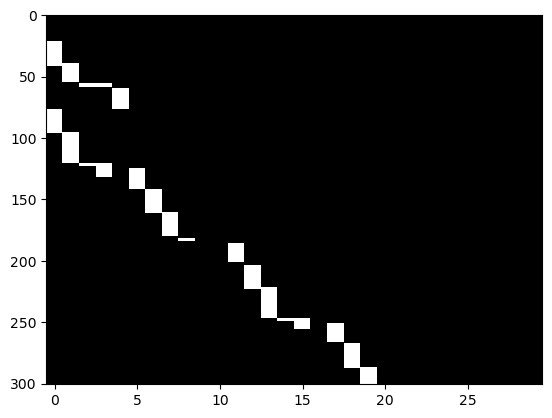

In [4]:
# Reality check for design matrix
plt.imshow(desmtx[:30], aspect='auto', cmap='gray', interpolation='nearest')

### Create data generation function

Here we generate data by adding independent Gaussian noise.  This is not realistic for fMRI, but it should not affect the results of the simulations qualitatively.

(6350, 1)


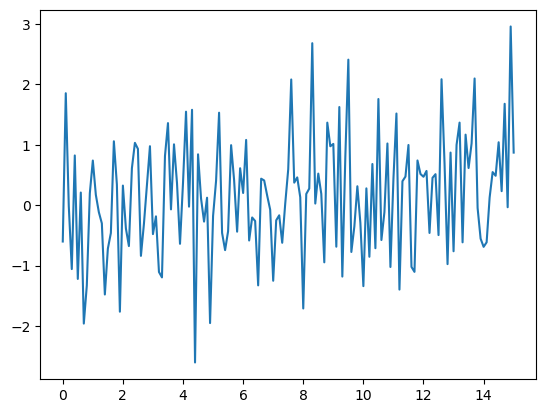

In [5]:

beta_dict = {'Cue_LargeGain': 1, 'Cue_SmallGain': 1} 
data = generate_data(desmtx_conv, beta_dict)
print(data.shape)
plt.plot(data.data[:15])


### Create models of interest

Here we create three models, based on those used in the Demidenko et al., 2024 multiverse analyses.

In [6]:
# create the three models
# all models include feedback for hit/miss in each condition
# then we use the relevant regressors for each model to create the
# anticipation regressor


# set all designs to have the same order of columns
def reorder_cols(df, probeRTmod=False):
    conds = ['NoMoneyStake', 'LargeGain', 'SmallGain', 'LargeLoss', 'SmallLoss']
    regs = ['Ant', 'Feedback_Hit', 'Feedback_Miss']
    if probeRTmod:
        regs.append('ProbeRTmod')
    newcols = []
    for cond in conds:
        for reg in regs:
            newcols.append(f'{reg}_{cond}')
    assert set(df.columns) == set(newcols), f'Columns do not match: {set(df.columns)} != {set(newcols)}'
    return df[newcols]

def create_models(desmtx):

    # 1. MID: Cue Onset, Cue Duration only 
    CueOnly = desmtx.copy()
    CueOnly = dropcols(CueOnly, ['Anticipation', 'Probe'])
    # rename CUE to ANT
    for col in CueOnly.columns:
        if 'ue' in col:
            CueOnly.rename(columns={col: col.replace('Cue', 'Ant')}, inplace=True)
    CueOnly = reorder_cols(CueOnly)

    # 2. MID: Cue Onset, Cue + Fixation Duration
    CueFix = desmtx.copy()
    for col in CueFix.columns:
        if 'Anticipation' in col:
            new_colname = col.replace('Anticipation', 'Ant')
            # combine cue and fixation regressors and clip to deal with overlap
            CueFix[new_colname] = np.clip(CueFix[col.replace('Anticipation', 'Cue')].values + CueFix[col].values, 0, 1)
    CueFix = dropcols(CueFix, ['Cue', 'Anticipation', 'Probe'])
    CueFix = reorder_cols(CueFix)

    # 3. MID: Fixation onset, Fixation Duration
    FixOnly = desmtx.copy()
    FixOnly = dropcols(FixOnly, ['Cue', 'Probe'])
    # rename FIXATION to ANT
    for col in FixOnly.columns:
        if 'Anticipation' in col:
            FixOnly.rename(columns={col: col.replace('Anticipation', 'Ant')}, inplace=True)
    FixOnly = reorder_cols(FixOnly)

    # 4. MID: Cue Onset, Cue Duration only plus RT modulated Probe
    CueOnlyRTmod = desmtx.copy()
    CueOnlyRTmod = dropcols(CueOnlyRTmod, ['Anticipation', 'Probe_'])
    # rename CUE to ANT
    for col in CueOnlyRTmod.columns:
        if 'ue' in col:
            CueOnlyRTmod.rename(columns={col: col.replace('Cue', 'Ant')}, inplace=True)
    CueOnlyRTmod = reorder_cols(CueOnlyRTmod, probeRTmod=True)

    return {'CueOnly': CueOnly, 'CueFix': CueFix, 'FixOnly': FixOnly, 'CueOnlyRTmod': CueOnlyRTmod}

models = create_models(desmtx)
models_conv = {key: convolve_regressors(value) for key, value in models.items()}

# make sure all models have the same regressors - ignoring order
assert models['CueOnly'].columns.equals(models['CueFix'].columns)
assert models['CueOnly'].columns.equals(models['FixOnly'].columns)

In [7]:
models['CueOnlyRTmod'].columns

Index(['Ant_NoMoneyStake', 'Feedback_Hit_NoMoneyStake',
       'Feedback_Miss_NoMoneyStake', 'ProbeRTmod_NoMoneyStake',
       'Ant_LargeGain', 'Feedback_Hit_LargeGain', 'Feedback_Miss_LargeGain',
       'ProbeRTmod_LargeGain', 'Ant_SmallGain', 'Feedback_Hit_SmallGain',
       'Feedback_Miss_SmallGain', 'ProbeRTmod_SmallGain', 'Ant_LargeLoss',
       'Feedback_Hit_LargeLoss', 'Feedback_Miss_LargeLoss',
       'ProbeRTmod_LargeLoss', 'Ant_SmallLoss', 'Feedback_Hit_SmallLoss',
       'Feedback_Miss_SmallLoss', 'ProbeRTmod_SmallLoss'],
      dtype='object')

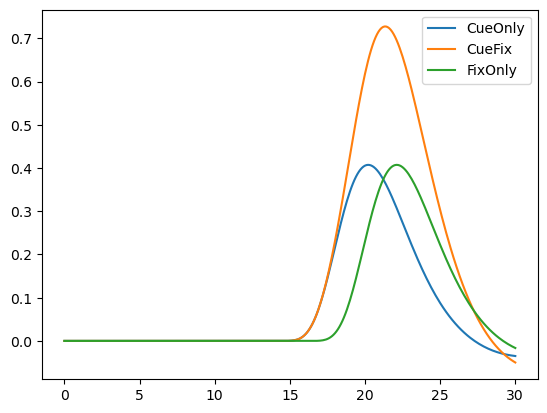

In [8]:
# plot regressors for reality check
plt.plot(models_conv['CueOnly']['Ant_NoMoneyStake'][:30])
plt.plot(models_conv['CueFix']['Ant_NoMoneyStake'][:30])
plt.plot(models_conv['FixOnly']['Ant_NoMoneyStake'][:30])
plt.legend(['CueOnly', 'CueFix', 'FixOnly'])

### Estimate the model and run contrasts

Here we run the model using OLS (which is appropriate given the noise structure) and estimate the four most common contrasts for the MID task based on Demidenko et al. (2020) review of the literature.

In [9]:
model = run_model(models_conv['CueOnlyRTmod'], data)
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                   data   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     77.59
Date:                Wed, 08 May 2024   Prob (F-statistic):          1.76e-282
Time:                        14:08:35   Log-Likelihood:                -9095.5
No. Observations:                6350   AIC:                         1.823e+04
Df Residuals:                    6329   BIC:                         1.837e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

## ABCD contrasts:

from Chaarani et al 2021:
```
MID-computed contrasts of interest were:
large reward versus neutral anticipation,
small reward versus neutral anticipation,
large loss versus neutral anticipation,
small loss versus neutral anticipation,
reward positive versus negative feedback and
loss positive versus negative feedback
```

We will focus on four of these (excluding the loss anticipation contrasts, since they should in theory look similar to the gain ones).

In [10]:
def get_contrasts(model):
    # Common contrasts from Demidenko 2020:
    # Based on my prior literature check, the distributions of contrasts: Across 37 studies 61 modeled contrasts:
    # Anticipation (n = 43, 70%):
    # 49% - All Win > Neutral
    # 16% Big Win > Neutral
    # 14% Big Win > Small Win
    # 12% Loss > Neutral
    # 9% others (Big Loss > Neutral; Small Win > Neutral; Win (or Loss) > Implicit Baseline)
    # Outcome (n = 8, 13%):
    # 34% Reward Hit > Neutral Hit
    # 25% Big Win Hit > Big Win Miss
    # 38% others (Big Win Hit > Neutral Hit; Big Win Miss > Neutral Miss; Loss Miss > Neutral Miss)

    contrast_dict = {}
    # large reward versus neutral anticipation
    c1 = np.zeros(len(model.params))
    c1[model.params.index == 'Ant_LargeGain'] = 1
    c1[model.params.index == 'Ant_NoMoneyStake'] = -1
    contrast_dict['Ant:LgRew-Neutral'] = c1

    # small reward versus neutral anticipation
    c2 = np.zeros(len(model.params))
    c2[model.params.index == 'Ant_SmallGain'] = 1
    c2[model.params.index == 'Ant_NoMoneyStake'] = -1
    contrast_dict['Ant:SmRew-Neutral'] = c2

    # reward positive versus negative feedback
    c3 = np.zeros(len(model.params))
    c3[model.params.index == 'Feedback_Hit_LargeGain'] = 0.5
    c3[model.params.index == 'Feedback_Miss_LargeGain'] = -0.5
    c3[model.params.index == 'Feedback_Hit_SmallGain'] = 0.5
    c3[model.params.index == 'Feedback_Miss_SmallGain'] = -0.5
    contrast_dict['FB:RewHit-RewMiss'] = c3
    
    # loss positive versus negative feedback
    c4 = np.zeros(len(model.params))
    c4[model.params.index == 'Feedback_Hit_LargeLoss'] = 0.5
    c4[model.params.index == 'Feedback_Miss_LargeLoss'] = -0.5
    c3[model.params.index == 'Feedback_Hit_SmallLoss'] = 0.5
    c3[model.params.index == 'Feedback_Miss_SmallLoss'] = -0.5
    contrast_dict['FB:LossHit-LossMiss'] = c4

    contrasts = [c1, c2, c3, c4]
    result = model.t_test(contrasts).summary_frame()[['coef', 'P>|t|']]
    result['contrast'] = contrast_dict.keys()
    return result, contrast_dict

t_test_results, contrast_dict = get_contrasts(model)
print(t_test_results)



        coef         P>|t|             contrast
c0 -2.699788  1.337689e-75    Ant:LgRew-Neutral
c1 -1.383787  3.566224e-21    Ant:SmRew-Neutral
c2 -0.105287  6.077913e-01    FB:RewHit-RewMiss
c3  0.156229  1.430550e-01  FB:LossHit-LossMiss


## Run simulations for all models in several true signal scenarios

In each of the following, we generate a true signal for specific components of the design, and assess the results for the most common contrasts.

Note: The SNR was adjusted manually for each simulation based on pilot results in order to give detection power of roughly 90% for the best contrast/model, to maximize the dynamic range for the full set of contrasts/models.




In [11]:
## important modeling parameters

nsims = 1000  # number of simulations per subject
overwrite = False  # overwrite existing data

# load existing data if they are there
if os.path.exists('all_sims_abcd.pkl') and not overwrite:
    with open('all_sims_abcd.pkl', 'rb') as f:
        all_sims = pickle.load(f)
    print(f'Loaded simulations from file.')
    print(all_sims.keys())
else:
    all_sims = {}

Loaded simulations from file.
dict_keys(['null', 'CUE:W-Neut', 'FIX:W-Neut', 'CUEFIX:W-Neut', 'PROBE:RTmod', 'FB:WHit-NeutHit', 'FB:LWHit-LWmiss'])


### Null model

In [12]:
def process_subject(sub, beta_dict, noise_sd, resolution=.1, verbose=False):
    all_results = None
    try:
        events = get_ABCD_subdata(sub)
    except:
        if verbose:
            print(f'Error loading sub {sub}')
        return None
    desmtx, desmtx_conv  = create_design_matrix(events, resolution=resolution)
    models = create_models(desmtx)
    models_conv = {key: convolve_regressors(value) for key, value in models.items()}
    data = generate_data(desmtx_conv, beta_dict, noise_sd=noise_sd)
    for key, model_desmtx in models_conv.items():
        model_results = run_model(model_desmtx, data)
        t_test_results, contrast_dict = get_contrasts(model_results)
        t_test_results['sub'] = sub
        t_test_results['model'] = key
        if all_results is None:
            all_results = t_test_results
        else:
            all_results = pd.concat([all_results, t_test_results])
    return all_results


def summarize_results(results, threshold=.05):
    summary = []
    for contrast in results.contrast.unique():
        for model in results.model.unique():
            # do one-sample t-test across subjects
            coefs = results.query('contrast == @contrast').query('model == @model')['coef']
            # assert len(coefs) == 107, f'Bad number of subjects: {len(coefs)}'
            assert coefs.isnull().sum() == 0, f'Nans in coefs'
            ttest = ttest_1samp(coefs, 0, alternative='greater')
            contrast_df = [contrast, model, ttest.statistic, ttest.pvalue,
                ttest.pvalue < threshold, coefs.mean()]
            summary.append(contrast_df)
    summary_df = pd.DataFrame(summary, columns=['contrast', 'model', 'tstat', 'pval', 'sigp', 'mean'])
    return summary_df


def resultlist_to_df(results, verbose=False):
    all_results = None
    for i, result in enumerate(results):
        if result is None:
            if verbose:
                print(f'Error in simulation {i + 1} - result is empty')
            continue
        if all_results is None:
            all_results = result
        else:
            all_results = pd.concat([all_results, result])
    all_results.reset_index(drop=True, inplace=True)
    return all_results

def run_simulation(beta_dict, nsims=100, threshold=0.05, noise_sd=1.0, resolution=.1, n_jobs=None):
    if n_jobs is None:
        n_jobs = multiprocessing.cpu_count() - 2  # save two cores for the OS
    all_results = None
    if len(beta_dict) == 0:
        true_signal = 'null'
    else:
        true_signal = beta_dict
    print(f'Running simulation for {true_signal}')
    for sim in tqdm(range(nsims)):  # wrap range with tqdm for progress bar
        sim_results = None
        results = Parallel(n_jobs=n_jobs)(
            delayed(process_subject)(i, beta_dict, noise_sd) for i in range(100)
            )
        sim_results = resultlist_to_df(results)
        summary = summarize_results(sim_results, threshold)
        summary['sim'] = sim
        if all_results is None:
            all_results = summary
        else:
            all_results = pd.concat([all_results, summary])
    return all_results



In [13]:
if 'null' not in all_sims.keys():
    beta_dict = {} 
    noise_sd = 1.0
    all_sims['null'] = run_simulation(beta_dict, nsims=nsims, noise_sd=noise_sd, resolution=.1)

/var/folders/r2/f85nyfr1785fj4257wkdj7480000gn/T/ipykernel_58684/3766789459.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)
/var/folders/r2/f85nyfr1785fj4257wkdj7480000gn/T/ipykernel_58684/3766789459.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)


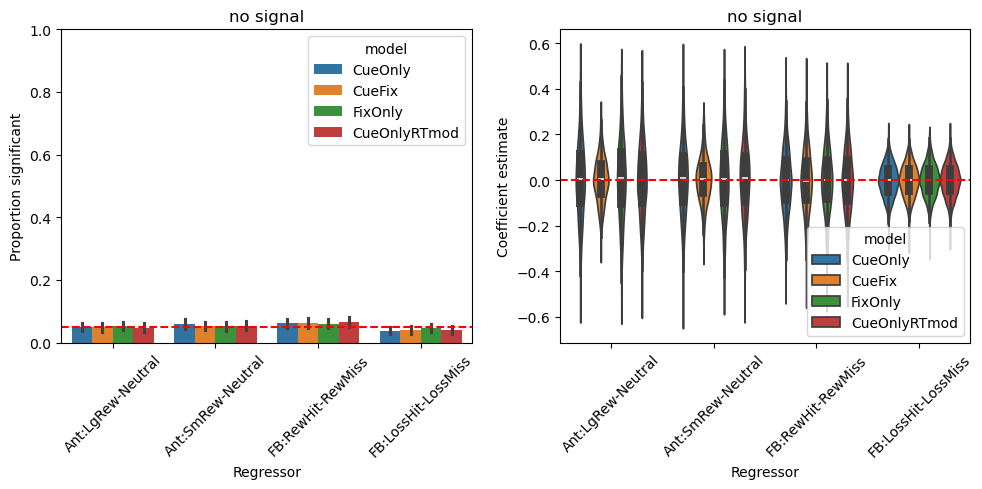

In [14]:
def plot_results(results_df, noise_sd, label):
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    sns.barplot(data=results_df, x='contrast', y='sigp', hue='model', ax=axs[0])
    axs[0].set_title(label)
    axs[0].set_ylim(0,1)
    axs[0].axhline(0.05, color='red', linestyle='--')
    axs[0].set_xlabel('Regressor')
    axs[0].set_ylabel('Proportion significant')
    axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)

    sns.violinplot(data=results_df, x='contrast', y='mean', hue='model', ax=axs[1])
    axs[1].axhline(0.0, color='red', linestyle='--')
    axs[1].set_xlabel('Regressor')
    axs[1].set_ylabel('Coefficient estimate')
    axs[1].set_title(label)
    axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)

    plt.tight_layout()
    plt.show()

plot_results(all_sims['null'], 1, 'no signal')

### True effect for CUE_Largegain and CUE_Smallgain

In [15]:
beta_dict = {'Cue_LargeGain': 0.5, 'Cue_SmallGain': 0.5} 
noise_sd = 1
if 'CUE:W-Neut' not in all_sims.keys():
    all_sims['CUE:W-Neut'] = run_simulation(beta_dict, nsims=nsims, noise_sd=noise_sd, resolution=.1)

/var/folders/r2/f85nyfr1785fj4257wkdj7480000gn/T/ipykernel_58684/3766789459.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)
/var/folders/r2/f85nyfr1785fj4257wkdj7480000gn/T/ipykernel_58684/3766789459.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)


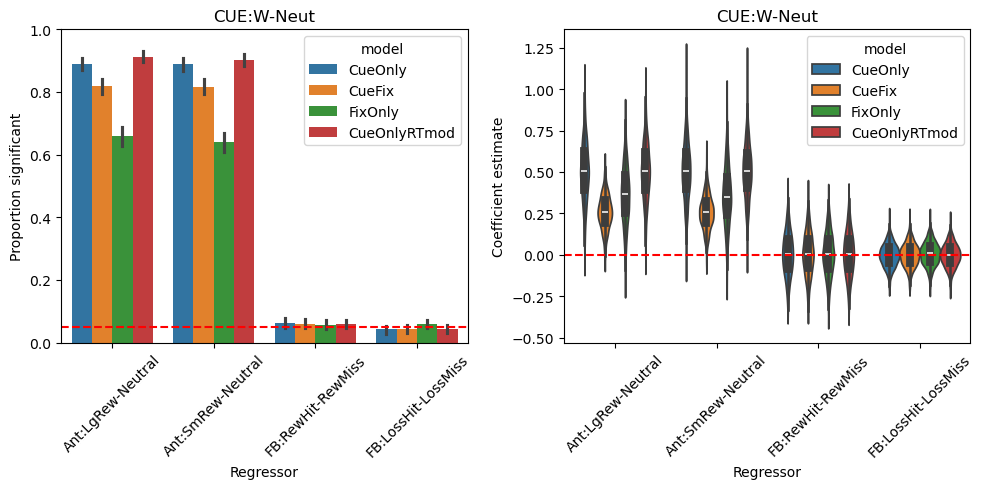

In [16]:
plot_results(all_sims['CUE:W-Neut'], noise_sd, 'CUE:W-Neut')

### True effect for Fixation_Smallgain and Fixation_Largegain

In [17]:
beta_dict = {'Anticipation_LargeGain': 0.5, 'Anticipation_SmallGain': 0.5} 
noise_sd = 1
if 'FIX:W-Neut' not in all_sims.keys():
    all_sims['FIX:W-Neut'] = run_simulation(beta_dict, nsims=nsims, noise_sd=noise_sd, resolution=.1)

/var/folders/r2/f85nyfr1785fj4257wkdj7480000gn/T/ipykernel_58684/3766789459.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)
/var/folders/r2/f85nyfr1785fj4257wkdj7480000gn/T/ipykernel_58684/3766789459.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)


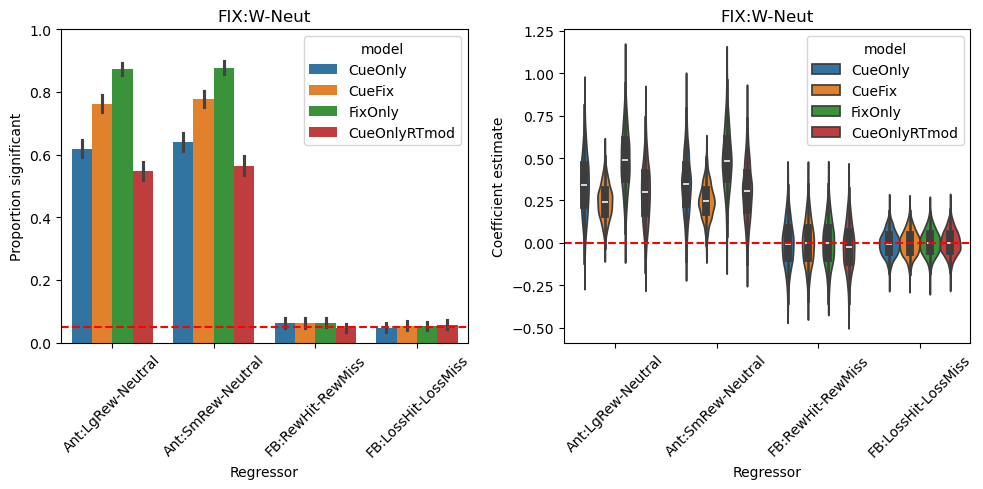

In [18]:
plot_results(all_sims['FIX:W-Neut'], noise_sd, 'FIX:W-Neut')

### True effect for both cue and fixation (i.e. "anticipation") for large/small gain

In [19]:
beta_dict = {'Cue_LargeGain': 0.25, 'Cue_SmallGain': 0.25, 'Anticipation_LargeGain': 0.25, 'Anticipation_SmallGain': 0.25} 
noise_sd = 1
if 'CUEFIX:W-Neut' not in all_sims.keys():
    all_sims['CUEFIX:W-Neut'] = run_simulation(beta_dict, nsims=nsims, noise_sd=noise_sd, resolution=.1)

/var/folders/r2/f85nyfr1785fj4257wkdj7480000gn/T/ipykernel_58684/3766789459.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)
/var/folders/r2/f85nyfr1785fj4257wkdj7480000gn/T/ipykernel_58684/3766789459.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)


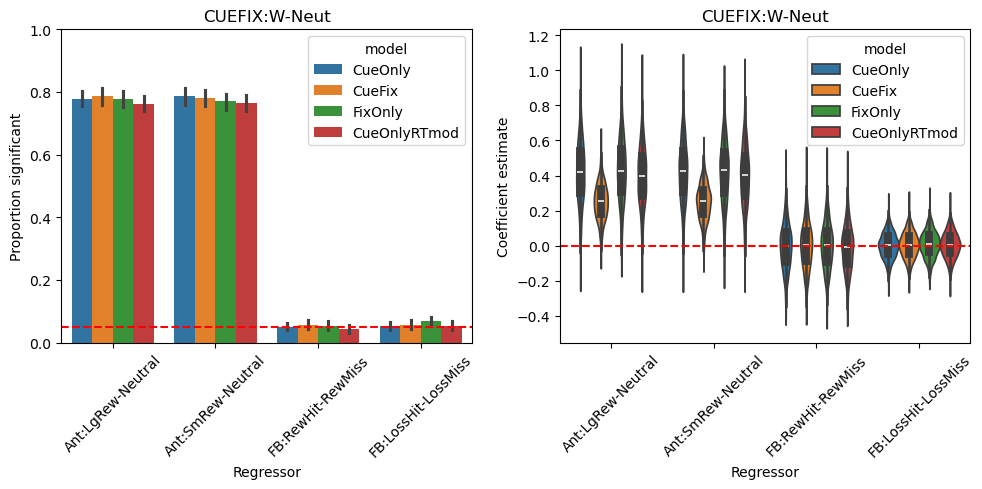

In [20]:
plot_results(all_sims['CUEFIX:W-Neut'], noise_sd, 'CUEFIX:W-Neut')

### True activation for RT_modulated Probe in all conditions

In [21]:
probeRT_signal = 5

beta_dict = {'ProbeRTmod_NoMoneyStake': probeRT_signal, 
             'ProbeRTmod_SmallGain': probeRT_signal,
             'ProbeRTmod_LargeGain': probeRT_signal,
             'ProbeRTmod_SmallLoss': probeRT_signal,
             'ProbeRTmod_LargeLoss': probeRT_signal} 
noise_sd = 1

if 'PROBE:RTmod' not in all_sims.keys():
    all_sims['PROBE:RTmod'] = run_simulation(beta_dict, nsims=nsims, noise_sd=noise_sd, resolution=.1)

/var/folders/r2/f85nyfr1785fj4257wkdj7480000gn/T/ipykernel_58684/3766789459.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)
/var/folders/r2/f85nyfr1785fj4257wkdj7480000gn/T/ipykernel_58684/3766789459.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)


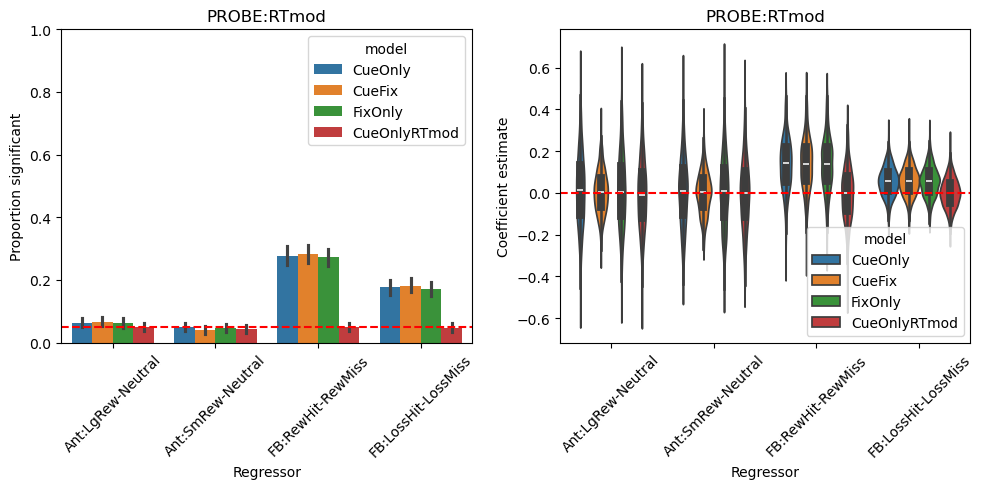

In [22]:
plot_results(all_sims['PROBE:RTmod'], noise_sd, 'PROBE:RTmod')

### True activation for win-hit vs neutral hit

In [23]:
beta_dict = {'Feedback_Hit_LargeGain': 0.5, 'Feedback_Hit_SmallGain': 0.5} 
noise_sd = 1
if 'FB:WHit-NeutHit' not in all_sims.keys():
    all_sims['FB:WHit-NeutHit'] = run_simulation(beta_dict, nsims=nsims, noise_sd=noise_sd, resolution=.1)

/var/folders/r2/f85nyfr1785fj4257wkdj7480000gn/T/ipykernel_58684/3766789459.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)
/var/folders/r2/f85nyfr1785fj4257wkdj7480000gn/T/ipykernel_58684/3766789459.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)


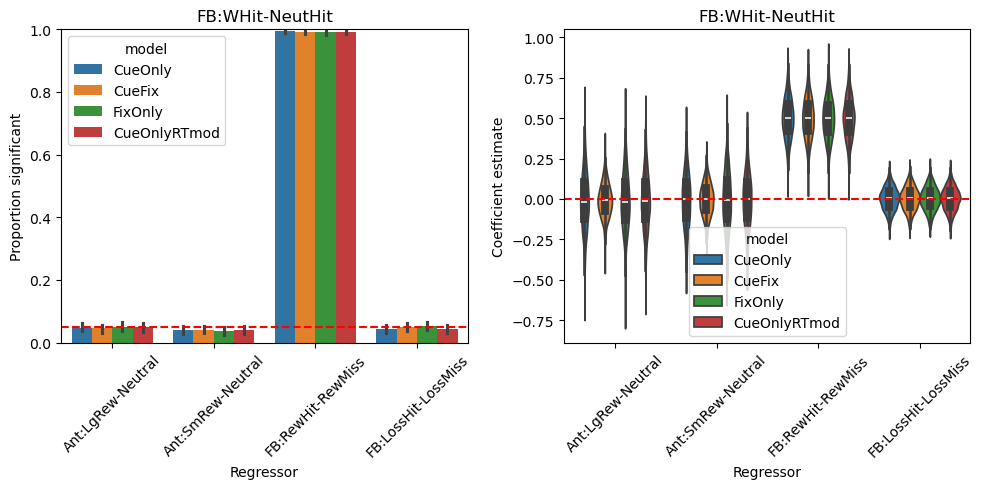

In [24]:
plot_results(all_sims['FB:WHit-NeutHit'], noise_sd, 'FB:WHit-NeutHit')

### True activation for Feedback LWHit vs LWMiss

In [25]:
beta_dict = {'Feedback_Hit_LargeGain': 0.25, 'Feedback_Miss_LargeGain': -0.25} 
noise_sd = 1
if 'FB:LWHit-LWMiss' not in all_sims.keys():
    all_sims['FB:LWHit-LWmiss'] = run_simulation(beta_dict, nsims=nsims, noise_sd=noise_sd, resolution=.1)

Running simulation for {'Feedback_Hit_LargeGain': 0.25, 'Feedback_Miss_LargeGain': -0.25}


  1%|          | 6/1000 [00:10<27:06,  1.64s/it]

/var/folders/r2/f85nyfr1785fj4257wkdj7480000gn/T/ipykernel_28867/3766789459.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)
/var/folders/r2/f85nyfr1785fj4257wkdj7480000gn/T/ipykernel_28867/3766789459.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)


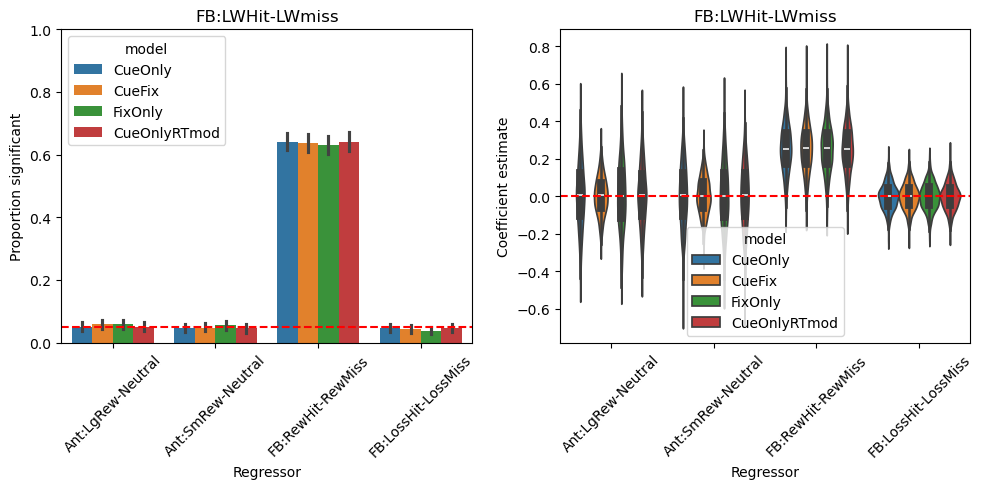

In [ ]:
plot_results(all_sims['FB:LWHit-LWmiss'], noise_sd, 'FB:LWHit-LWmiss')

### Store the results

In [ ]:
with open('all_sims_abcd.pkl', 'wb') as f:
    pickle.dump(all_sims, f)